In [142]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
import pandas as pd
from datasets import load_dataset

dataset_name = "human_immune_health_atlas_20k_single_no_caption_cs50"
dataset = load_dataset(f"jo-mengr/{dataset_name}")
test_dataset = dataset["test"]

# test_dataset = load_dataset("jo-mengr/human_pancreas_norm_complexBatch_single")["train"]

In [144]:
from sentence_transformers import SentenceTransformer

model_name = "mmcontext-cg_100k-natural_language_annotation-pubmedbert-2048-geneformer-sample_cs"
model = SentenceTransformer(f"jo-mengr/{model_name}")
primary_cell_sentence = "cell_sentence_1"
label_key = "AIFI_L2"
batch_key = "batch_id"
text_only = False

Loaded encoder was registered for 'geneformer' data. Call register_initial_embeddings() with compatible data before using it.


In [145]:
og_text_encoder = model[0].text_encoder_name
text_encoder = SentenceTransformer(og_text_encoder)

In [146]:
from mmcontext.file_utils import load_test_adata_from_hf_dataset, subset_dataset_by_chunk

adata, local_path = load_test_adata_from_hf_dataset(test_dataset, save_dir=f"../../data/from_nxtcloud/{dataset_name}")
adata, train_sub = subset_dataset_by_chunk(adata, test_dataset)

Processing: 100%|██████████| 1/1 [00:00<00:00, 12865.96file/s]
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/anndata/_io/specs/registry.py:281: OldFormatWarning: Element '/obsm/X_geneformer' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/anndata/_io/specs/registry.py:281: OldFormatWarning: Element '/obsm/X_hvg' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/anndata/_io/specs/registry.py:281: OldFormatWarning: Element '/obsm/X_scvi_fm' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < 

In [147]:
if "pairs" in dataset_name:
    test_dataset = test_dataset.filter(lambda x: x["label"] == 1.0)

In [148]:
if not text_only:
    token_df, _ = model[0].get_initial_embeddings(
        dataset,
        layer_key="X_geneformer",
        download_dir=f"../../data/from_nxtcloud/{dataset_name}",
        axis="obs",
    )
    model[0].register_initial_embeddings(token_df, data_origin="geneformer")

Processing: 100%|██████████| 1/1 [00:00<00:00, 11715.93file/s]
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/anndata/_io/specs/registry.py:281: OldFormatWarning: Element '/obsm/X_geneformer' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/anndata/_io/specs/registry.py:281: OldFormatWarning: Element '/obsm/X_hvg' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/anndata/_io/specs/registry.py:281: OldFormatWarning: Element '/obsm/X_scvi_fm' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)


Use the returned DataFrame to register the embeddings with `register_initial_embeddings()`.


In [149]:
# enc.register_initial_embeddings(token_df, data_origin="geneformer")
dataset_ready = model[0].prepare_ds(dataset, primary_cell_sentence_col=primary_cell_sentence, prefix=not text_only)

/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


In [150]:
dataset_to_use = dataset_ready["test"]

In [151]:
dataset_to_use[0]

{'cell_sentence_1': 'sample_idx:10f27ae2671711ed94878208818934b6'}

In [153]:
omics_embeddings = model.encode(dataset_to_use[primary_cell_sentence])
text_embeddings = model.encode(adata.obs[label_key].values.tolist())

adata.obsm["mmcontext_emb"] = omics_embeddings
adata.obsm["mmcontext_text_emb"] = text_embeddings
adata.obsm["og_text_emb"] = text_encoder.encode(adata.obs[label_key].values.tolist())
adata.obsm["og_text_omics_emb"] = text_encoder.encode(dataset_to_use[primary_cell_sentence])

In [154]:
adata.obs[batch_key] = adata.obs[batch_key].astype("category")
# make Nans to "other" in batch
adata.obs[batch_key] = adata.obs[batch_key].cat.add_categories("other")
adata.obs[batch_key].fillna("other", inplace=True)

/var/folders/x3/bj_4mgb56c19542qzptvc36c0000gn/T/ipykernel_68234/3531224074.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adata.obs[batch_key].fillna("other", inplace=True)


<Figure size 800x800 with 0 Axes>

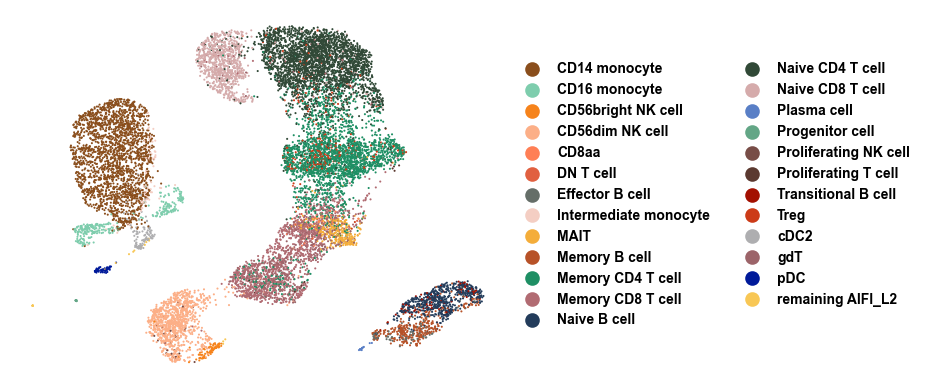

In [155]:
# Visualise the embeddings
from mmcontext.pl import plot_umap
from mmcontext.utils import consolidate_low_frequency_categories

current_key = label_key
adata_cut = consolidate_low_frequency_categories(adata, [current_key], threshold=10)
emb_key = "mmcontext_emb"
plot_umap(
    adata_cut,
    color_key=label_key,
    embedding_key=emb_key,
    save_format="svg",
    nametag=f"neurons_{label_key}",
    save_dir=f"figs/{model_name}/{dataset_name}",
    save_plot=False,
    title="",
)

<Figure size 800x800 with 0 Axes>

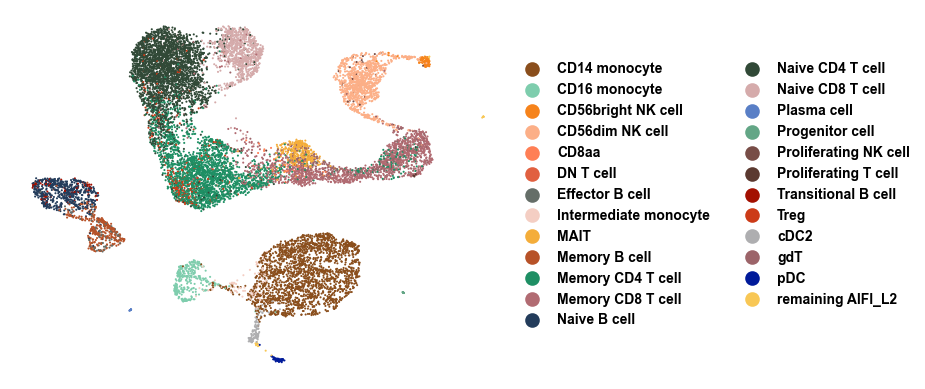

In [156]:
# Visualise the embeddings
from mmcontext.pl import plot_umap
from mmcontext.utils import consolidate_low_frequency_categories

current_key = label_key
adata_cut = consolidate_low_frequency_categories(adata, [current_key], threshold=10)
emb_key = "X_geneformer"
plot_umap(
    adata_cut,
    color_key=label_key,
    embedding_key=emb_key,
    save_format="svg",
    nametag=f"neurons_{label_key}",
    save_dir=f"figs/{model_name}/{dataset_name}",
    save_plot=False,
    title="",
)

In [173]:
adata.obs["AIFI_L2"].value_counts()

AIFI_L2
Naive CD4 T cell         2820
Memory CD4 T cell        2430
CD14 monocyte            2032
Memory CD8 T cell        1388
CD56dim NK cell          1011
Naive CD8 T cell          897
Naive B cell              587
gdT                       369
MAIT                      338
Memory B cell             329
CD16 monocyte             303
Treg                      285
cDC2                      106
Effector B cell            86
Intermediate monocyte      85
Transitional B cell        78
CD56bright NK cell         77
pDC                        57
CD8aa                      41
Proliferating NK cell      23
remaining AIFI_L2          22
Plasma cell                16
DN T cell                  15
Proliferating T cell       13
Progenitor cell            12
Name: count, dtype: int64

In [177]:
df = pd.read_csv("../../data/queries/additional_combined.csv")
labels = df["Cell Type"]
Definition = df["Definition"]

In [190]:
from mmcontext.eval.query_annotate import OmicsQueryAnnotator
from mmcontext.pl.plotting import plot_query_scores_with_labels_umap

annotator = OmicsQueryAnnotator(model)
annotator.query_with_text(adata, Definition, emb_key="mmcontext_emb")
# Call the plotting function
plot_query_scores_with_labels_umap(
    adata=adata,
    queries=Definition,
    labels=labels,
    label_key="AIFI_L2",
    save_dir="figs/umap_with_labels",
    nametag="demo",
    figsize=(4, 4),
    point_size=10,
    dpi=300,  # Lower DPI for faster generation
    axis_label_size=18,
    axis_tick_size=18,
)

In [189]:
from mmcontext.eval.registry import get as get_evaluator

ev_name = "LabelSimilarity"
EvClass = get_evaluator(ev_name)
ev = EvClass()

In [128]:
from mmcontext.eval.utils import create_emb_pair_dataframe

emb_pair_df = create_emb_pair_dataframe(
    adata,
    emb1_key="mmcontext_emb",
    emb2_key="mmcontext_text_emb",
    subset_size=20,
    label_keys=["_scvi_batch", "cell_type"],
)

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/utils.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  base_row[label_key] = adata.obs[label_key][sampled_indices[idx]]


/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


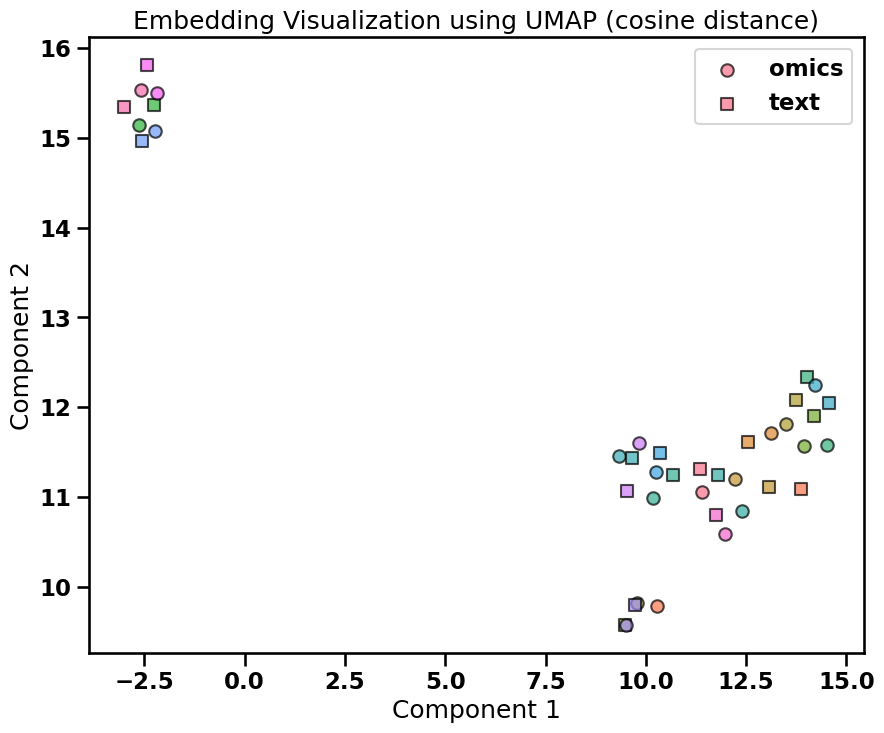

In [125]:
from mmcontext.pl import visualize_embedding_clusters

visualize_embedding_clusters(emb_pair_df, method="umap", metric="cosine", n_neighbors=15, min_dist=0.1, random_state=42)

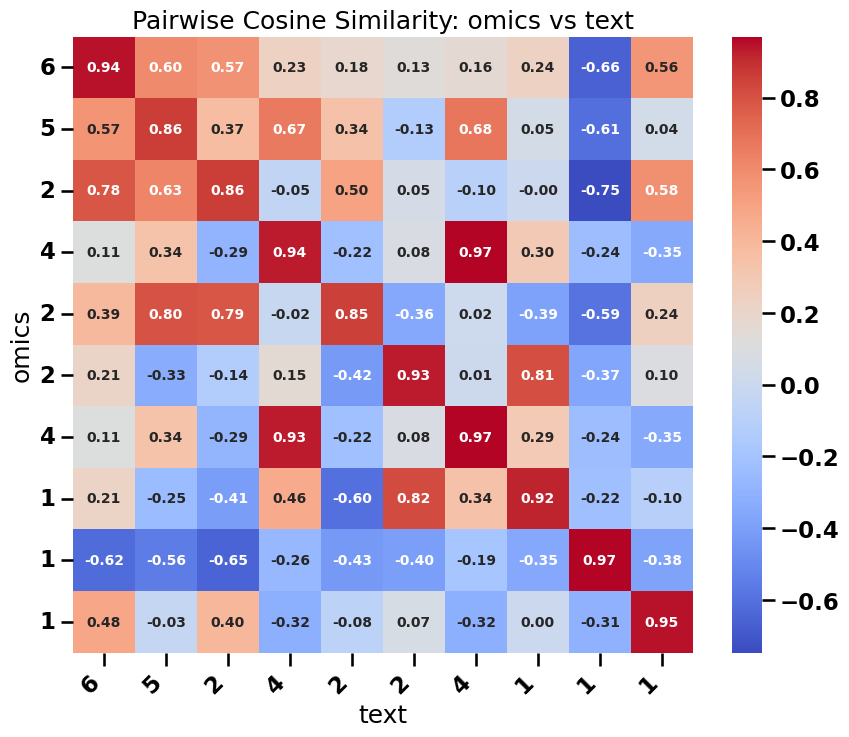

In [147]:
from mmcontext.pl.plotting import plot_embedding_similarity

plot_embedding_similarity(emb_pair_df, emb1_type="omics", emb2_type="text", subset=10, label_key="_scvi_batch")

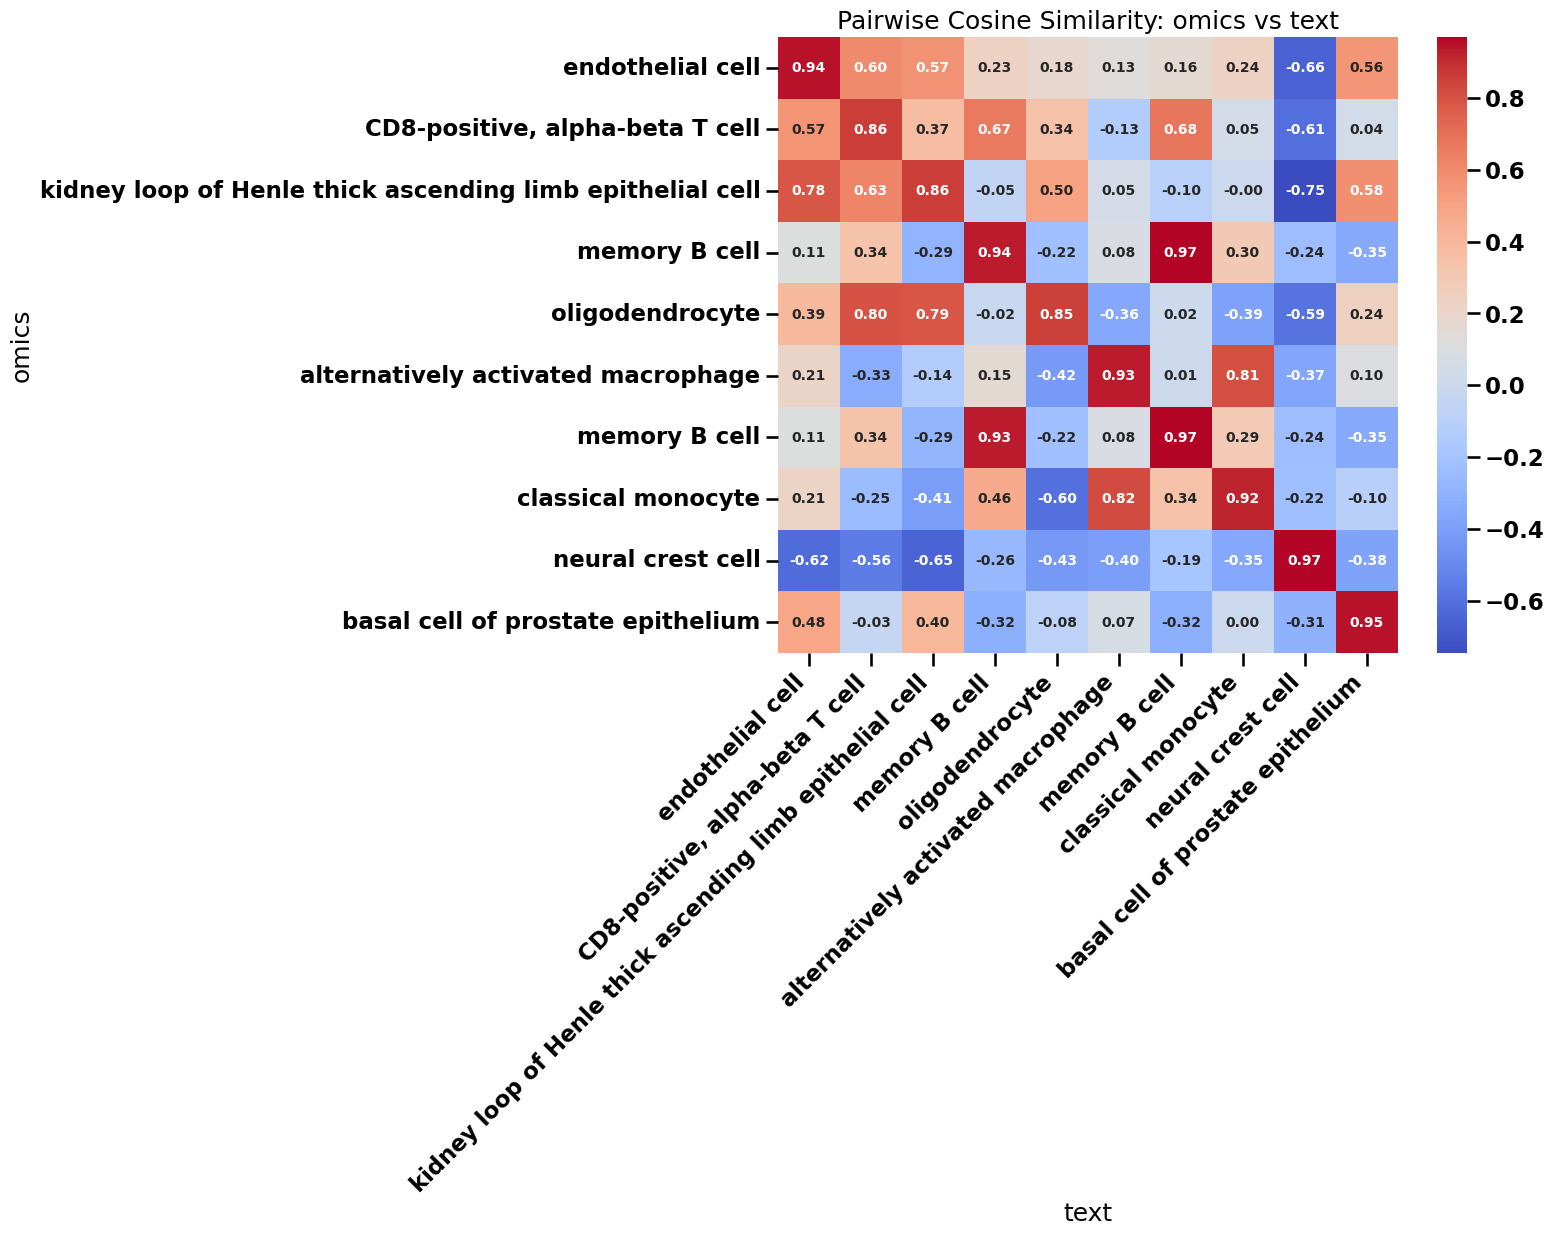

In [148]:
from mmcontext.pl.plotting import plot_embedding_similarity

plot_embedding_similarity(emb_pair_df, emb1_type="omics", emb2_type="text", subset=10, label_key="cell_type")

In [96]:
from mmcontext.eval.utils import create_emb_pair_dataframe

# only show similarities within one batch
emb_pair_df = create_emb_pair_dataframe(
    adata,
    emb1_key="mmcontext_emb",
    emb2_key="mmcontext_text_emb",
    subset_size=100,
    obs_filter_key="_scvi_batch",
    obs_filter_value=2,
)

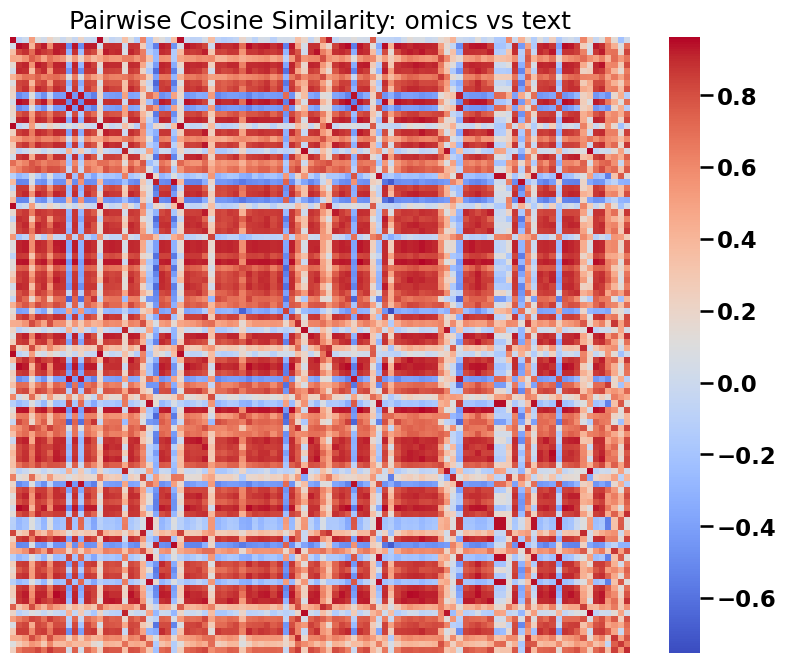

In [98]:
from mmcontext.pl.plotting import plot_embedding_similarity

plot_embedding_similarity(emb_pair_df, emb1_type="omics", emb2_type="text", subset=100)

In [1]:
from mmcontext.pp import remove_zero_variance_cells, remove_zero_variance_genes

adata = remove_zero_variance_cells(adata)
adata = remove_zero_variance_genes(adata)

/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'adata' is not defined

In [42]:
from mmcontext.eval import scibEvaluator

evalutator = scibEvaluator(
    adata=adata,
    batch_key="batch",
    label_key="cluster_lavel",
    embedding_key=["mmcontext_emb", "mmcontext_text_emb", "X_geneformer", "X_hvg", "X_pca", "X_scvi"],
    n_top_genes=5000,
    max_cells=5000,
)
res = evalutator.evaluate()

HVG


Error in data reduction: Bin edges must be unique: Index([               -inf,  -2.892823703725029, -0.6085385346302277,
       0.09924078048896734, 0.09924078048896734, 0.09924079373444396,
       0.14027225325936107, 0.18885910880786402, 0.23705809401106778,
          0.30732003013017,  0.4241397468442167,   0.611900446591554,
        0.9100024470921467,  1.3157359159517066,  1.9957290970961805,
         2.822801220996513,   3.787105232711744,    5.15218205363662,
         7.423641985710012,  100.20904103227615,                 inf],
      dtype='float64').
You can drop duplicate edges by setting the 'duplicates' kwarg
Using full data for metrics computation.


HVG
Cluster for cluster_0.2 with leiden


KeyError: 'No "neighbors" in .uns'